# TESTING MODELS

Let us try a few classification models
## Classical ML models

In [1]:
import pandas as pd
import time
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, multilabel_confusion_matrix, accuracy_score, classification_report, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
models = []

In [3]:
df = pd.read_csv('data/cleaned_train.csv')
feats = []
with open('data/features.txt','r') as f:
    feats = [x[:-1] for x in f.readlines()]
df.shape, df.columns, feats

((75018, 53),
 Index(['id', 'marital_status', 'appln_mode', 'appln_order', 'prog_of_study',
        'morn/eve_attend', 'prev_edu', 'prev_edu_grade', 'nationality',
        'mom_edu', 'dad_edu', 'mom_occup', 'admission_grade', 'was_displaced',
        'edu_spl_need', 'has_student_debt', 'no_fee_dues', 'gender',
        'got_scholarship', 'age_at_start', 'sem1_units_credited',
        'sem1_units_enrolled', 'sem1_units_eval', 'sem1_units_approved',
        'sem1_units_grade', 'sem1_units_no_eval', 'sem2_units_credited',
        'sem2_units_enrolled', 'sem2_units_eval', 'sem2_units_approved',
        'sem2_units_grade', 'sem2_units_no_eval', 'unemployment_rate',
        'inflation', 'gdp', 'Target', 'marital_status_log', 'appln_order_log',
        'prog_of_study_log', 'morn/eve_attend_log', 'prev_edu_log',
        'mom_occup_log', 'edu_spl_need_log', 'has_student_debt_log',
        'no_fee_dues_log', 'got_scholarship_log', 'age_at_start_log',
        'sem1_units_credited_log', 'sem1_units

We use only the selected features

In [4]:
X,y = df.drop(columns=['Target','id','nationality']).values, df['Target'].values

(Target
 Graduate    36603
 Dropout     23669
 Enrolled    14746
 Name: count, dtype: int64,
 <Axes: >)

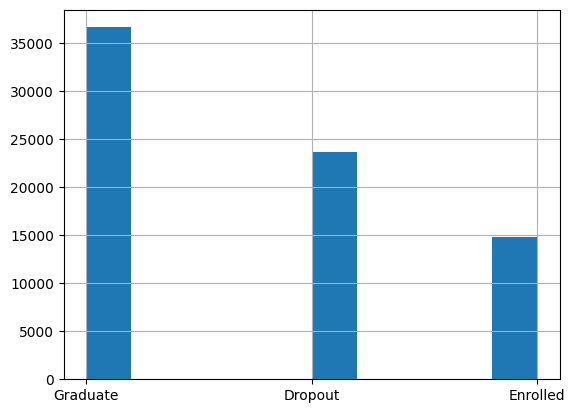

In [5]:
df['Target'].value_counts(), df['Target'].hist()

So we have an imbalanced dataset. To handle this - for classical ML models, we oversample the smaller classes

In [6]:
# Train test split
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y_l = le.fit(y)
y_enc = y_l.transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y_enc, test_size=0.2, random_state=42)

### Decision tree

First we check the performance without any oversampling

In [7]:
from sklearn import tree

In [8]:
%%time
model_dt = tree.DecisionTreeClassifier()
start = time.perf_counter()
model_dt.fit(X_train,y_train)
end = time.perf_counter()

CPU times: total: 797 ms
Wall time: 860 ms


In [9]:
y_pred = model_dt.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9393,   912],
        [  800,  3899]],

       [[10545,  1498],
        [ 1420,  1541]],

       [[ 6496,  1164],
        [ 1354,  5990]]], dtype=int64)

In [10]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7219383685073244, 0.7617968541722208)

In [11]:
print('DECISION TREE - NO PREPROCESSING')
x = classification_report(y_val, y_pred, labels = sorted(list(set(y_enc))), digits=4, output_dict=True)
models.append({'model':'Decision_tree_no_preprocessing', 'metrics': x, 'training_time(s)':(end-start)})
pd.DataFrame(models)

DECISION TREE - NO PREPROCESSING


,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8104344211182706, 'recal...",0.860545


Next, let us use `SMOTE` (Synthetic Minority Over-sampling Technique) to oversample the minority classes

In [12]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [13]:
#Apply Over Sampling
print(f'Before Oversampling {sorted(Counter(y_train).items())}')
X_train1, y_train1 = SMOTE().fit_resample(X_train, y_train)
print(f'After Oversampling {sorted(Counter(y_train1).items())}')

Before Oversampling [(0, 18970), (1, 11785), (2, 29259)]
After Oversampling [(0, 29259), (1, 29259), (2, 29259)]


In [14]:
%%time
model_dt = tree.DecisionTreeClassifier()
start = time.perf_counter()
model_dt.fit(X_train1,y_train1)
end = time.perf_counter()

CPU times: total: 2.7 s
Wall time: 2.77 s


In [15]:
y_pred = model_dt.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9437,   868],
        [  775,  3924]],

       [[10509,  1534],
        [ 1374,  1587]],

       [[ 6519,  1141],
        [ 1394,  5950]]], dtype=int64)

In [16]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7270746851567201, 0.7638629698747)

In [17]:
print('DECISION TREE - SMOTE')
x = classification_report(y_val, y_pred, labels = sorted(list(set(y_enc))), digits=4, output_dict=True)
models.append({'model':'Decision_tree_oversampling', 'metrics': x, 'training_time(s)':(end-start)})
pd.DataFrame(models)

DECISION TREE - SMOTE


,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8104344211182706, 'recal...",0.860545
1,Decision_tree_oversampling,"{'0': {'precision': 0.8188647746243739, 'recal...",2.772430


Let us try an undersampler

In [18]:
from imblearn.under_sampling import RandomUnderSampler

In [19]:
#Apply Random Under Sampling
rus = RandomUnderSampler(random_state=0)
print(f'Before Undersampling {sorted(Counter(y_train).items())}')
X_train1, y_train1 =rus.fit_resample(X_train, y_train)
print(f'After Undersampling {sorted(Counter(y_train1).items())}')

Before Undersampling [(0, 18970), (1, 11785), (2, 29259)]
After Undersampling [(0, 11785), (1, 11785), (2, 11785)]


In [20]:
%%time
model_dt = tree.DecisionTreeClassifier()
start = time.perf_counter()
model_dt.fit(X_train1,y_train1)
end = time.perf_counter()

CPU times: total: 266 ms
Wall time: 619 ms


In [21]:
y_pred = model_dt.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[9415,  890],
        [ 847, 3852]],

       [[9875, 2168],
        [1068, 1893]],

       [[6795,  865],
        [2008, 5336]]], dtype=int64)

In [22]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7285464823348464, 0.7385363902959211)

In [23]:
print('DECISION TREE - Random Undersampler')
x = classification_report(y_val, y_pred, labels = sorted(list(set(y_enc))), digits=4, output_dict=True)
models.append({'model':'Decision_tree_undersampling', 'metrics': x, 'training_time(s)':(end-start)})
pd.DataFrame(models)

DECISION TREE - Random Undersampler


,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8104344211182706, 'recal...",0.860545
1,Decision_tree_oversampling,"{'0': {'precision': 0.8188647746243739, 'recal...",2.772430
2,Decision_tree_undersampling,"{'0': {'precision': 0.8123154787009701, 'recal...",0.618921


So, the performance is not vastly affected by the oversampling or undersampling => Decision tree is robust to imbalanced data

### Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
estims = [5,10,20,50,100,200,300]
model = RandomForestClassifier()
acc,tim = [], []
for x in estims:
    model = RandomForestClassifier(n_estimators=x,warm_start=True)
    start = time.perf_counter()
    model.fit(X_train,y_train)
    end = time.perf_counter()
    y_pred = model.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_estimators: {x}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_estimators: 5, time_taken: 0.6089823001530021s, accuracy: 0.798653692348707
n_estimators: 10, time_taken: 1.1606748001649976s, accuracy: 0.817981871500933
n_estimators: 20, time_taken: 2.5849787001498044s, accuracy: 0.8260463876299653
n_estimators: 50, time_taken: 6.402804699959233s, accuracy: 0.8325779792055452
n_estimators: 100, time_taken: 12.281118700047955s, accuracy: 0.8337776592908558
n_estimators: 200, time_taken: 25.394146300153807s, accuracy: 0.8361770194614769
n_estimators: 300, time_taken: 36.25085399998352s, accuracy: 0.836910157291389


Pick best model

In [26]:
model1 = RandomForestClassifier(n_estimators=estims[np.argmax(acc)],warm_start=True)
start = time.perf_counter()
model1.fit(X_train,y_train)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {x}, time_taken: {end-start}s, accuracy: {_acc}')

n_estimators: 300, time_taken: 34.53130759997293s, accuracy: 0.8358437749933351


In [27]:
model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(n_estimators=300, warm_start=True)>

In [28]:
y_pred = model.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'RandomForest_no_preprocessing', 'metrics': x, 'training_time(s)': tim[-1]})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8104344211182706, 'recal...",0.860545
1,Decision_tree_oversampling,"{'0': {'precision': 0.8188647746243739, 'recal...",2.772430
2,Decision_tree_undersampling,"{'0': {'precision': 0.8123154787009701, 'recal...",0.618921
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9459261071690727, 'recal...",36.250854


Text(0.5, 1.0, 'Training time')

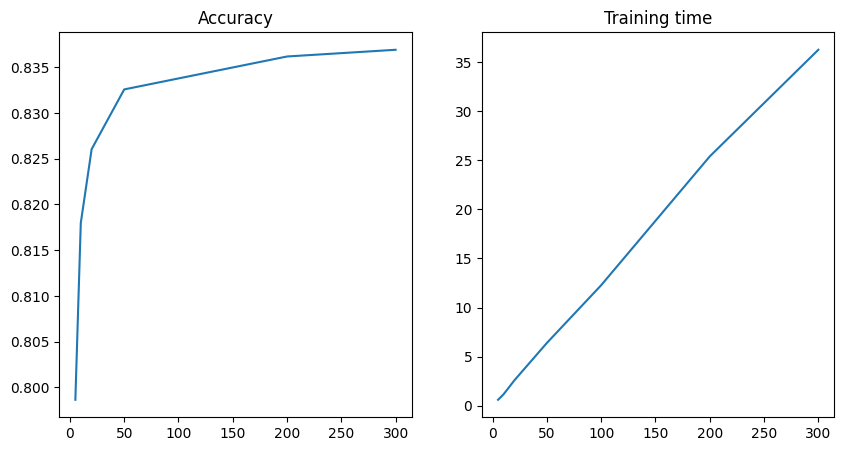

In [29]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(estims,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(estims,tim)
ax2.set_title('Training time')

Try with SMOTE

In [30]:
X_train1, y_train1 = SMOTE().fit_resample(X_train,y_train)
estims = [5,10,20,50,100,200,300]
model = RandomForestClassifier()
acc,tim = [], []
for x in estims:
    model = RandomForestClassifier(n_estimators=x,warm_start=True)
    start = time.perf_counter()
    model.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_estimators: {x}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_estimators: 5, time_taken: 1.8180452999658883s, accuracy: 0.7990535857104772
n_estimators: 10, time_taken: 3.404166700085625s, accuracy: 0.8167155425219942
n_estimators: 20, time_taken: 6.501640300033614s, accuracy: 0.8281791522260731
n_estimators: 50, time_taken: 16.40562820015475s, accuracy: 0.8348440415889096
n_estimators: 100, time_taken: 32.49802020005882s, accuracy: 0.8325779792055452
n_estimators: 200, time_taken: 66.96973069990054s, accuracy: 0.8339776059717409
n_estimators: 300, time_taken: 101.39715679991059s, accuracy: 0.83564382831245


Pick best model

In [31]:
model1 = RandomForestClassifier(n_estimators=estims[np.argmax(acc)],warm_start=True)
start = time.perf_counter()
model1.fit(X_train1,y_train1)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {estims[np.argmax(acc)]}, time_taken: {end-start}s, accuracy: {_acc}')

n_estimators: 300, time_taken: 98.9995502999518s, accuracy: 0.834377499333511


In [32]:
model.feature_importances_

array([0.00085794, 0.00897412, 0.00755175, 0.01164801, 0.00071681,
       0.00178633, 0.02061613, 0.01145813, 0.0116095 , 0.01225075,
       0.02306628, 0.00645983, 0.00037726, 0.00543462, 0.01897722,
       0.01150224, 0.02124396, 0.01744002, 0.0016583 , 0.01042399,
       0.03599685, 0.09925293, 0.07892178, 0.0015296 , 0.00145869,
       0.01152203, 0.04579482, 0.13567061, 0.10590674, 0.00163278,
       0.01366853, 0.01252585, 0.01434493, 0.00086169, 0.00776939,
       0.01214518, 0.00071196, 0.00183338, 0.01218886, 0.00036751,
       0.00576726, 0.02233614, 0.02062314, 0.01790347, 0.00173623,
       0.05433655, 0.00153454, 0.00148508, 0.07454675, 0.00157353])

In [33]:
y_pred = model.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'RandomForest_oversampling', 'metrics': x, 'training_time(s)': tim[-1]})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8104344211182706, 'recal...",0.860545
1,Decision_tree_oversampling,"{'0': {'precision': 0.8188647746243739, 'recal...",2.772430
2,Decision_tree_undersampling,"{'0': {'precision': 0.8123154787009701, 'recal...",0.618921
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9459261071690727, 'recal...",36.250854
4,RandomForest_oversampling,"{'0': {'precision': 0.9539915443919423, 'recal...",101.397157


Text(0.5, 1.0, 'Training time')

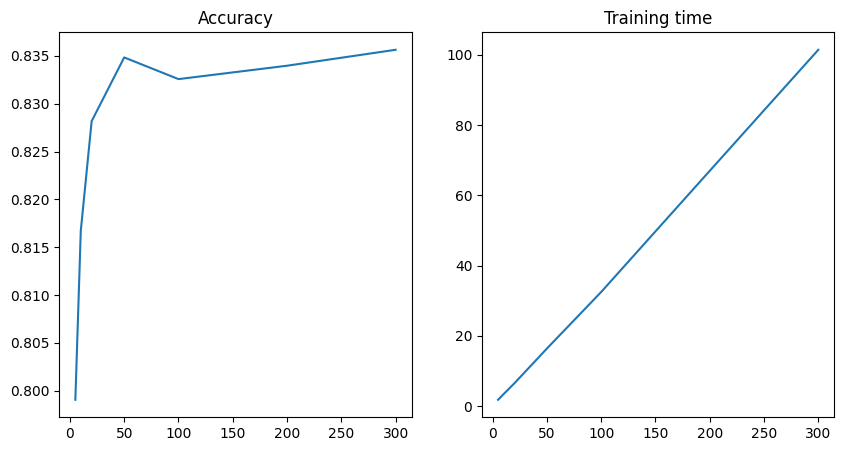

In [34]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(estims,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(estims,tim)
ax2.set_title('Training time')


Let's try Undersampling

In [35]:
X_train1, y_train1 = RandomUnderSampler().fit_resample(X_train,y_train)
estims = [5,10,20,50,100,200,300]
model = RandomForestClassifier()
acc,tim = [], []
for x in estims:
    model = RandomForestClassifier(n_estimators=x,warm_start=True)
    start = time.perf_counter()
    model.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_estimators: {x}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_estimators: 5, time_taken: 0.36110900016501546s, accuracy: 0.7777259397494002
n_estimators: 10, time_taken: 0.6810815001372248s, accuracy: 0.7886563583044521
n_estimators: 20, time_taken: 1.3805982999037951s, accuracy: 0.8091175686483605
n_estimators: 50, time_taken: 3.455957799917087s, accuracy: 0.8140495867768595
n_estimators: 100, time_taken: 7.123992399778217s, accuracy: 0.8147827246067715
n_estimators: 200, time_taken: 13.74379640002735s, accuracy: 0.81851506264996
n_estimators: 300, time_taken: 20.6800759001635s, accuracy: 0.817248733671021


Pick best model

In [36]:
model1 = RandomForestClassifier(n_estimators=estims[np.argmax(acc)],warm_start=True)
start = time.perf_counter()
model1.fit(X_train1,y_train1)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {estims[np.argmax(acc)]}, time_taken: {end-start}s, accuracy: {_acc}')

n_estimators: 200, time_taken: 14.040627799928188s, accuracy: 0.8180485203945614


In [37]:
model.feature_importances_

array([0.00081896, 0.01184638, 0.00864269, 0.01626438, 0.00095103,
       0.00221041, 0.02727008, 0.01435757, 0.01448313, 0.01414406,
       0.03256432, 0.00577364, 0.00037044, 0.00404876, 0.01520154,
       0.00707941, 0.01037703, 0.01808894, 0.00200347, 0.00924107,
       0.03530893, 0.0799825 , 0.08446286, 0.00171391, 0.00168897,
       0.00969641, 0.04045545, 0.11661102, 0.1147253 , 0.00172241,
       0.01586665, 0.01445497, 0.01670839, 0.00080484, 0.00865909,
       0.01585285, 0.00096574, 0.0022575 , 0.01435852, 0.00039243,
       0.00414923, 0.01577076, 0.01146035, 0.01780459, 0.00198026,
       0.06707819, 0.00165465, 0.00163189, 0.08428108, 0.00176295])

In [38]:
y_pred = model.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'RandomForest_undersampling', 'metrics': x, 'training_time(s)': tim[-1]})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8104344211182706, 'recal...",0.860545
1,Decision_tree_oversampling,"{'0': {'precision': 0.8188647746243739, 'recal...",2.772430
2,Decision_tree_undersampling,"{'0': {'precision': 0.8123154787009701, 'recal...",0.618921
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9459261071690727, 'recal...",36.250854
4,RandomForest_oversampling,"{'0': {'precision': 0.9539915443919423, 'recal...",101.397157
5,RandomForest_undersampling,"{'0': {'precision': 0.971882322311898, 'recall...",20.680076


Text(0.5, 1.0, 'Training time')

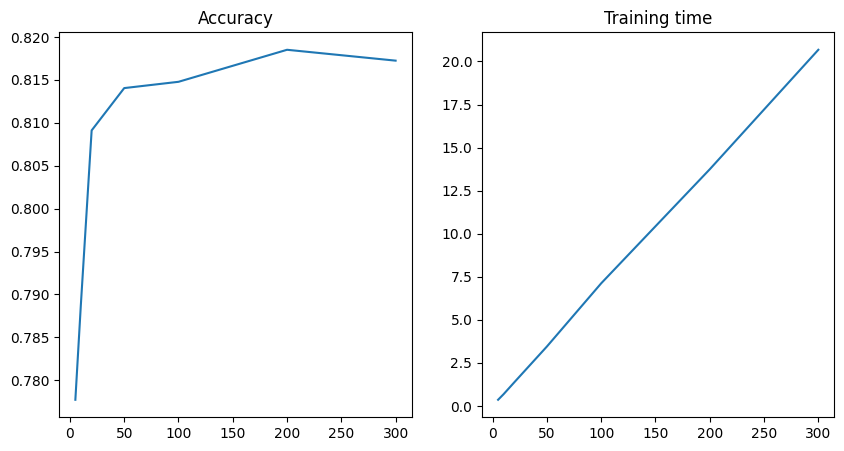

In [39]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(estims,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(estims,tim)
ax2.set_title('Training time')


### Naive Bayes

In [40]:
from sklearn.naive_bayes import GaussianNB

In [41]:
%%time
model_nb = GaussianNB()
start = time.perf_counter()
model_nb.fit(X_train, y_train)
end = time.perf_counter()

CPU times: total: 46.9 ms
Wall time: 66.8 ms


In [42]:
y_pred = model_nb.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9667,   638],
        [ 1001,  3698]],

       [[10821,  1222],
        [ 1635,  1326]],

       [[ 5905,  1755],
        [  979,  6365]]], dtype=int64)

In [43]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7004971779922178, 0.7590642495334577)

In [44]:
print('NAIVE BAYES - No preprocessing')
x = classification_report(y_val, y_pred, labels = sorted(list(set(y_enc))), digits=4, output_dict=True)
models.append({'model':'Naive_Bayes_no_preprocessing', 'metrics': x, 'training_time(s)':(end-start)})
pd.DataFrame(models)

NAIVE BAYES - No preprocessing


,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8104344211182706, 'recal...",0.860545
1,Decision_tree_oversampling,"{'0': {'precision': 0.8188647746243739, 'recal...",2.772430
2,Decision_tree_undersampling,"{'0': {'precision': 0.8123154787009701, 'recal...",0.618921
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9459261071690727, 'recal...",36.250854
4,RandomForest_oversampling,"{'0': {'precision': 0.9539915443919423, 'recal...",101.397157
5,RandomForest_undersampling,"{'0': {'precision': 0.971882322311898, 'recall...",20.680076
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.066764


Let's try oversampling 

In [45]:
X_train1, y_train1 = SMOTE().fit_resample(X_train, y_train)

In [46]:
%%time
model_nb = GaussianNB()
start = time.perf_counter()
model_nb.fit(X_train1,y_train1)
end = time.perf_counter()

CPU times: total: 328 ms
Wall time: 97.6 ms


In [47]:
y_pred = model_nb.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9633,   672],
        [  984,  3715]],

       [[10381,  1662],
        [ 1212,  1749]],

       [[ 6452,  1208],
        [ 1346,  5998]]], dtype=int64)

In [48]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7326645669895434, 0.7639296187683284)

In [49]:
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'Naive_Bayes_oversampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8104344211182706, 'recal...",0.860545
1,Decision_tree_oversampling,"{'0': {'precision': 0.8188647746243739, 'recal...",2.772430
2,Decision_tree_undersampling,"{'0': {'precision': 0.8123154787009701, 'recal...",0.618921
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9459261071690727, 'recal...",36.250854
4,RandomForest_oversampling,"{'0': {'precision': 0.9539915443919423, 'recal...",101.397157
5,RandomForest_undersampling,"{'0': {'precision': 0.971882322311898, 'recall...",20.680076
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.066764
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8468201504444951, 'recal...",0.096846


Let's try undersampling

In [50]:
X_train1, y_train1 = RandomUnderSampler().fit_resample(X_train, y_train)

In [51]:
%%time
model_nb = GaussianNB()
start = time.perf_counter()
model_nb.fit(X_train1,y_train1)
end = time.perf_counter()

CPU times: total: 31.2 ms
Wall time: 46.5 ms


In [52]:
y_pred = model_nb.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9675,   630],
        [ 1004,  3695]],

       [[10671,  1372],
        [ 1496,  1465]],

       [[ 6081,  1579],
        [ 1081,  6263]]], dtype=int64)

In [53]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7113026038378513, 0.7613303119168222)

In [54]:
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'Naive_Bayes_undersampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8104344211182706, 'recal...",0.860545
1,Decision_tree_oversampling,"{'0': {'precision': 0.8188647746243739, 'recal...",2.772430
2,Decision_tree_undersampling,"{'0': {'precision': 0.8123154787009701, 'recal...",0.618921
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9459261071690727, 'recal...",36.250854
4,RandomForest_oversampling,"{'0': {'precision': 0.9539915443919423, 'recal...",101.397157
5,RandomForest_undersampling,"{'0': {'precision': 0.971882322311898, 'recall...",20.680076
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.066764
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8468201504444951, 'recal...",0.096846
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8543352601156069, 'recal...",0.045773


### K Nearest Neighbors

In [55]:
from sklearn.neighbors import KNeighborsClassifier

In [56]:
nbors = [3,5,10,15,20,25,50,100,200,400,800]
tim, acc = [], []
model_knn = KNeighborsClassifier()

for n in nbors:
    model_knn = KNeighborsClassifier(n_neighbors=n)
    start = time.perf_counter()
    model_knn.fit(X_train,y_train)
    end = time.perf_counter()
    y_pred = model_knn.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_neighbors: {n}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_neighbors: 3, time_taken: 0.011399999959394336s, accuracy: 0.7342042122100774
n_neighbors: 5, time_taken: 0.00906129996292293s, accuracy: 0.7457344708077845
n_neighbors: 10, time_taken: 0.0109140002168715s, accuracy: 0.753998933617702
n_neighbors: 15, time_taken: 0.012708700029179454s, accuracy: 0.753998933617702
n_neighbors: 20, time_taken: 0.009556100005283952s, accuracy: 0.7530658491069048
n_neighbors: 25, time_taken: 0.011353400070220232s, accuracy: 0.751266328978939
n_neighbors: 50, time_taken: 0.008967699948698282s, accuracy: 0.7434684084244202
n_neighbors: 100, time_taken: 0.009389800019562244s, accuracy: 0.7292055451879499
n_neighbors: 200, time_taken: 0.007864300161600113s, accuracy: 0.7113436416955479
n_neighbors: 400, time_taken: 0.006646299967542291s, accuracy: 0.6866169021594242
n_neighbors: 800, time_taken: 0.007040600059553981s, accuracy: 0.6582244734737404


Pick best model

In [57]:
model1 = KNeighborsClassifier(n_neighbors=nbors[np.argmax(acc)])
start = time.perf_counter()
model1.fit(X_train,y_train)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {nbors[np.argmax(acc)]}, time_taken: {end-start}s, accuracy: {_acc}')
model1.get_params

n_estimators: 10, time_taken: 0.01722939987666905s, accuracy: 0.753998933617702


<bound method BaseEstimator.get_params of KNeighborsClassifier(n_neighbors=10)>

In [58]:
y_pred = model1.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'KNN_no_preprocessing', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8104344211182706, 'recal...",0.860545
1,Decision_tree_oversampling,"{'0': {'precision': 0.8188647746243739, 'recal...",2.772430
2,Decision_tree_undersampling,"{'0': {'precision': 0.8123154787009701, 'recal...",0.618921
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9459261071690727, 'recal...",36.250854
4,RandomForest_oversampling,"{'0': {'precision': 0.9539915443919423, 'recal...",101.397157
5,RandomForest_undersampling,"{'0': {'precision': 0.971882322311898, 'recall...",20.680076
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.066764
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8468201504444951, 'recal...",0.096846
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8543352601156069, 'recal...",0.045773
9,KNN_no_preprocessing,"{'0': {'precision': 0.8735545500251383, 'recal...",0.017229


Text(0.5, 1.0, 'Training time')

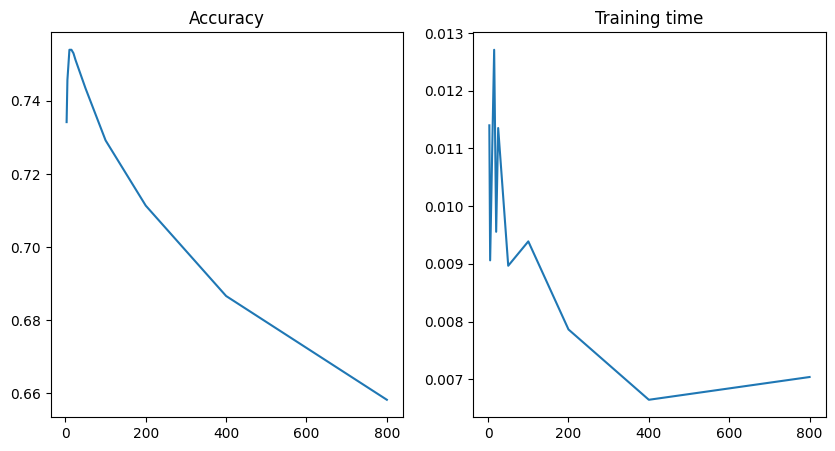

In [59]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(nbors,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(nbors,tim)
ax2.set_title('Training time')

Let's try oversampling

In [60]:
X_train1, y_train1 = SMOTE().fit_resample(X_train,y_train)

In [61]:
nbors = [3,5,10,15,20,25,50,100,200,400,800]
tim, acc = [], []
model_knn = KNeighborsClassifier()

for n in nbors:
    model_knn = KNeighborsClassifier(n_neighbors=n)
    start = time.perf_counter()
    model_knn.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model_knn.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_neighbors: {n}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_neighbors: 3, time_taken: 0.017633599927648902s, accuracy: 0.700079978672354
n_neighbors: 5, time_taken: 0.0168785999994725s, accuracy: 0.697880565182618
n_neighbors: 10, time_taken: 0.009318999946117401s, accuracy: 0.6998133830978406
n_neighbors: 15, time_taken: 0.011219499865546823s, accuracy: 0.7054118901626233
n_neighbors: 20, time_taken: 0.008675100049003959s, accuracy: 0.7022127432684617
n_neighbors: 25, time_taken: 0.01213450008071959s, accuracy: 0.7074113569714743
n_neighbors: 50, time_taken: 0.013422199990600348s, accuracy: 0.7019461476939483
n_neighbors: 100, time_taken: 0.009422200033441186s, accuracy: 0.6910157291388963
n_neighbors: 200, time_taken: 0.017044000094756484s, accuracy: 0.6778858970941083
n_neighbors: 400, time_taken: 0.007446100004017353s, accuracy: 0.6683551053052519
n_neighbors: 800, time_taken: 0.011323400074616075s, accuracy: 0.6454278858970941


Pick best model

In [62]:
model1 = KNeighborsClassifier(n_neighbors=nbors[np.argmax(acc)])
start = time.perf_counter()
model1.fit(X_train1,y_train1)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {nbors[np.argmax(acc)]}, time_taken: {end-start}s, accuracy: {_acc}')
model1.get_params

n_estimators: 25, time_taken: 0.014460899867117405s, accuracy: 0.7074113569714743


<bound method BaseEstimator.get_params of KNeighborsClassifier(n_neighbors=25)>

In [63]:
y_pred = model1.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'KNN_oversampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8104344211182706, 'recal...",0.860545
1,Decision_tree_oversampling,"{'0': {'precision': 0.8188647746243739, 'recal...",2.772430
2,Decision_tree_undersampling,"{'0': {'precision': 0.8123154787009701, 'recal...",0.618921
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9459261071690727, 'recal...",36.250854
4,RandomForest_oversampling,"{'0': {'precision': 0.9539915443919423, 'recal...",101.397157
5,RandomForest_undersampling,"{'0': {'precision': 0.971882322311898, 'recall...",20.680076
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.066764
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8468201504444951, 'recal...",0.096846
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8543352601156069, 'recal...",0.045773
9,KNN_no_preprocessing,"{'0': {'precision': 0.8735545500251383, 'recal...",0.017229


Text(0.5, 1.0, 'Training time')

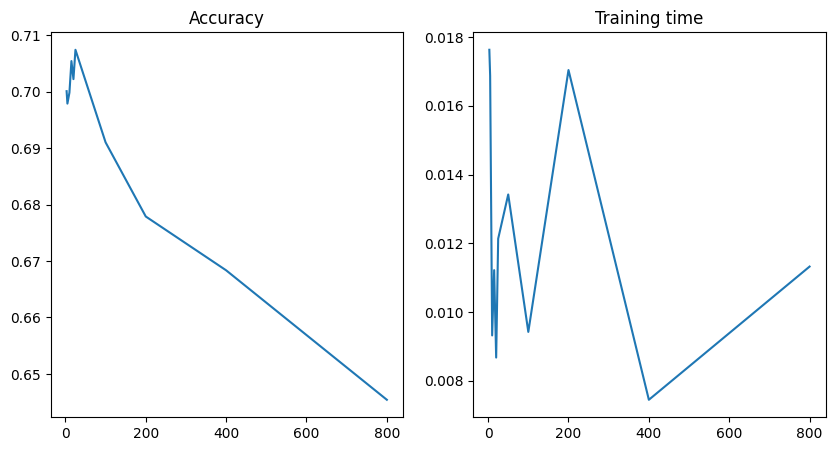

In [64]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(nbors,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(nbors,tim)
ax2.set_title('Training time')

Let's try undersampling

In [65]:
X_train1, y_train1 = RandomUnderSampler().fit_resample(X_train,y_train)

In [66]:
nbors = [3,5,10,15,20,25,50,100,200,400,800]
tim, acc = [], []
model_knn = KNeighborsClassifier()

for n in nbors:
    model_knn = KNeighborsClassifier(n_neighbors=n)
    start = time.perf_counter()
    model_knn.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model_knn.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_neighbors: {n}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_neighbors: 3, time_taken: 0.003234799951314926s, accuracy: 0.6920821114369502
n_neighbors: 5, time_taken: 0.003065400058403611s, accuracy: 0.7002132764596107
n_neighbors: 10, time_taken: 0.005631800042465329s, accuracy: 0.7078112503332444
n_neighbors: 15, time_taken: 0.00483600003644824s, accuracy: 0.7080778459077579
n_neighbors: 20, time_taken: 0.005287999985739589s, accuracy: 0.7070114636097041
n_neighbors: 25, time_taken: 0.002832199912518263s, accuracy: 0.7034790722474007
n_neighbors: 50, time_taken: 0.005228700116276741s, accuracy: 0.6944814716075713
n_neighbors: 100, time_taken: 0.008398100035265088s, accuracy: 0.6822847240735804
n_neighbors: 200, time_taken: 0.007755800150334835s, accuracy: 0.6648227139429486
n_neighbors: 400, time_taken: 0.002796499989926815s, accuracy: 0.638296454278859
n_neighbors: 800, time_taken: 0.003611000021919608s, accuracy: 0.6087043455078646


Pick best model

In [67]:
model1 = KNeighborsClassifier(n_neighbors=nbors[np.argmax(acc)])
start = time.perf_counter()
model1.fit(X_train1,y_train1)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {nbors[np.argmax(acc)]}, time_taken: {end-start}s, accuracy: {_acc}')
model1.get_params

n_estimators: 15, time_taken: 0.006567200180143118s, accuracy: 0.7080778459077579


<bound method BaseEstimator.get_params of KNeighborsClassifier(n_neighbors=15)>

In [68]:
y_pred = model1.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'KNN_undersampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8104344211182706, 'recal...",0.860545
1,Decision_tree_oversampling,"{'0': {'precision': 0.8188647746243739, 'recal...",2.772430
2,Decision_tree_undersampling,"{'0': {'precision': 0.8123154787009701, 'recal...",0.618921
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9459261071690727, 'recal...",36.250854
4,RandomForest_oversampling,"{'0': {'precision': 0.9539915443919423, 'recal...",101.397157
5,RandomForest_undersampling,"{'0': {'precision': 0.971882322311898, 'recall...",20.680076
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.066764
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8468201504444951, 'recal...",0.096846
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8543352601156069, 'recal...",0.045773
9,KNN_no_preprocessing,"{'0': {'precision': 0.8735545500251383, 'recal...",0.017229


Text(0.5, 1.0, 'Training time')

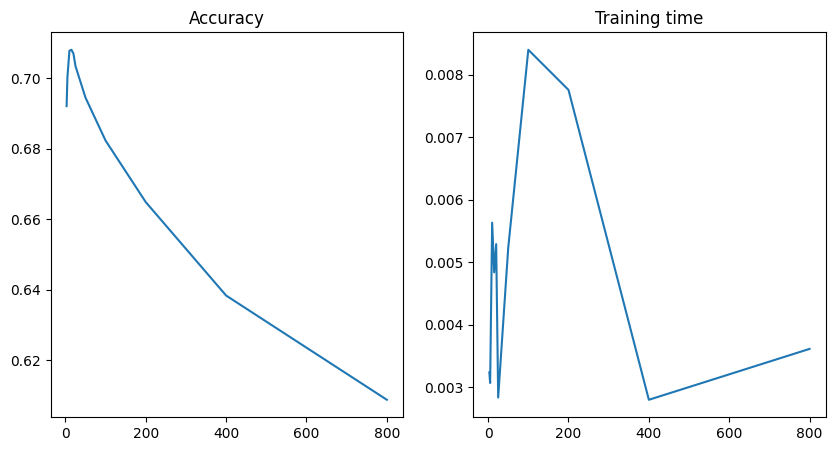

In [69]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(nbors,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(nbors,tim)
ax2.set_title('Training time')

### LightGBM

In [70]:
from lightgbm import LGBMClassifier

In [71]:
%%time
model = LGBMClassifier()
start = time.perf_counter()
model.fit(X_train,y_train)
end = time.perf_counter()
end-start

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1928
[LightGBM] [Info] Number of data points in the train set: 60014, number of used features: 50
[LightGBM] [Info] Start training from score -1.151719
[LightGBM] [Info] Start training from score -1.627750
[LightGBM] [Info] Start training from score -0.718391
CPU times: total: 8.41 s
Wall time: 1.29 s


1.2736665001139045

In [72]:
y_pred = model.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[10067,   238],
        [  798,  3901]],

       [[11037,  1006],
        [ 1072,  1889]],

       [[ 6478,  1182],
        [  556,  6788]]], dtype=int64)

In [73]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7974762403075025, 0.8383097840575846)

In [74]:
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'LightGBM_no_preprocessing', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8104344211182706, 'recal...",0.860545
1,Decision_tree_oversampling,"{'0': {'precision': 0.8188647746243739, 'recal...",2.772430
2,Decision_tree_undersampling,"{'0': {'precision': 0.8123154787009701, 'recal...",0.618921
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9459261071690727, 'recal...",36.250854
4,RandomForest_oversampling,"{'0': {'precision': 0.9539915443919423, 'recal...",101.397157
5,RandomForest_undersampling,"{'0': {'precision': 0.971882322311898, 'recall...",20.680076
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.066764
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8468201504444951, 'recal...",0.096846
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8543352601156069, 'recal...",0.045773
9,KNN_no_preprocessing,"{'0': {'precision': 0.8735545500251383, 'recal...",0.017229


Try SMOTE

In [75]:
X_train1,y_train1 = SMOTE().fit_resample(X_train,y_train)

In [76]:
%%time
model = LGBMClassifier()
start = time.perf_counter()
model.fit(X_train1,y_train1)
end = time.perf_counter()
end-start

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11703
[LightGBM] [Info] Number of data points in the train set: 87777, number of used features: 50
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
CPU times: total: 28.1 s
Wall time: 3.7 s


3.703258499968797

In [77]:
y_pred = model.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[10072,   233],
        [  792,  3907]],

       [[11002,  1041],
        [ 1014,  1947]],

       [[ 6536,  1124],
        [  592,  6752]]], dtype=int64)

In [78]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.8027972015305264, 0.8401759530791789)

In [79]:
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'LightGBM_oversampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8104344211182706, 'recal...",0.860545
1,Decision_tree_oversampling,"{'0': {'precision': 0.8188647746243739, 'recal...",2.772430
2,Decision_tree_undersampling,"{'0': {'precision': 0.8123154787009701, 'recal...",0.618921
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9459261071690727, 'recal...",36.250854
4,RandomForest_oversampling,"{'0': {'precision': 0.9539915443919423, 'recal...",101.397157
5,RandomForest_undersampling,"{'0': {'precision': 0.971882322311898, 'recall...",20.680076
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.066764
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8468201504444951, 'recal...",0.096846
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8543352601156069, 'recal...",0.045773
9,KNN_no_preprocessing,"{'0': {'precision': 0.8735545500251383, 'recal...",0.017229


Try Undersampling

In [80]:
X_train1,y_train1 = RandomUnderSampler().fit_resample(X_train,y_train)

In [81]:
%%time
model = LGBMClassifier()
start = time.perf_counter()
model.fit(X_train1,y_train1)
end = time.perf_counter()
end-start

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1890
[LightGBM] [Info] Number of data points in the train set: 35355, number of used features: 50
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
CPU times: total: 6.36 s
Wall time: 927 ms


0.9251995999366045

In [82]:
y_pred = model.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[10145,   160],
        [  903,  3796]],

       [[10253,  1790],
        [  604,  2357]],

       [[ 6941,   719],
        [ 1162,  6182]]], dtype=int64)

In [83]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.8152073041579774, 0.8221141029058917)

In [84]:
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'LightGBM_undersampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8104344211182706, 'recal...",0.860545
1,Decision_tree_oversampling,"{'0': {'precision': 0.8188647746243739, 'recal...",2.772430
2,Decision_tree_undersampling,"{'0': {'precision': 0.8123154787009701, 'recal...",0.618921
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9459261071690727, 'recal...",36.250854
4,RandomForest_oversampling,"{'0': {'precision': 0.9539915443919423, 'recal...",101.397157
5,RandomForest_undersampling,"{'0': {'precision': 0.971882322311898, 'recall...",20.680076
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.066764
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8468201504444951, 'recal...",0.096846
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8543352601156069, 'recal...",0.045773
9,KNN_no_preprocessing,"{'0': {'precision': 0.8735545500251383, 'recal...",0.017229


## Results

In [85]:
df_results = pd.DataFrame(models)

In [86]:
df_results['precision'] = df_results['metrics'].apply(lambda x: {0: round(x['0']['precision'],3), 1: round(x['1']['precision'],3), 2: round(x['2']['precision'],3)})
df_results['recall'] = df_results['metrics'].apply(lambda x: {0: round(x['0']['recall'],3), 1: round(x['1']['recall'],3), 2: round(x['2']['recall'],3)})
df_results['f1-score'] = df_results['metrics'].apply(lambda x: {0: round(x['0']['f1-score'],3), 1: round(x['1']['f1-score'],3), 2: round(x['2']['f1-score'],3)})
df_results['macro_avg'] = df_results['metrics'].apply(lambda x: {k: round(x['macro avg'][k],3) for k in x['macro avg'].keys()})
df_results['weighted_avg'] = df_results['metrics'].apply(lambda x: {k: round(x['weighted avg'][k],3) for k in x['weighted avg'].keys()})
df_results['accuracy'] = df_results['metrics'].apply(lambda x: round(x['accuracy'],3))
df_results['time (s)'] = df_results['training_time(s)']
df_results.drop(columns=['metrics','training_time(s)'],inplace=True)

In [87]:
df_results.to_csv('data/benchmarking_outliers_handled.csv',index=False)
df_results

,model,precision,recall,f1-score,macro_avg,weighted_avg,accuracy,time (s)
0,Decision_tree_no_preprocessing,"{0: 0.81, 1: 0.507, 2: 0.837}","{0: 0.83, 1: 0.52, 2: 0.816}","{0: 0.82, 1: 0.514, 2: 0.826}","{'precision': 0.718, 'recall': 0.722, 'f1-scor...","{'precision': 0.764, 'recall': 0.762, 'f1-scor...",0.762,0.860545
1,Decision_tree_oversampling,"{0: 0.819, 1: 0.508, 2: 0.839}","{0: 0.835, 1: 0.536, 2: 0.81}","{0: 0.827, 1: 0.522, 2: 0.824}","{'precision': 0.722, 'recall': 0.727, 'f1-scor...","{'precision': 0.768, 'recall': 0.764, 'f1-scor...",0.764,2.772430
2,Decision_tree_undersampling,"{0: 0.812, 1: 0.466, 2: 0.861}","{0: 0.82, 1: 0.639, 2: 0.727}","{0: 0.816, 1: 0.539, 2: 0.788}","{'precision': 0.713, 'recall': 0.729, 'f1-scor...","{'precision': 0.768, 'recall': 0.739, 'f1-scor...",0.739,0.618921
3,RandomForest_no_preprocessing,"{0: 0.946, 1: 0.652, 2: 0.848}","{0: 0.823, 1: 0.634, 2: 0.928}","{0: 0.88, 1: 0.643, 2: 0.886}","{'precision': 0.815, 'recall': 0.795, 'f1-scor...","{'precision': 0.84, 'recall': 0.837, 'f1-score...",0.837,36.250854
4,RandomForest_oversampling,"{0: 0.954, 1: 0.633, 2: 0.857}","{0: 0.816, 1: 0.673, 2: 0.913}","{0: 0.88, 1: 0.652, 2: 0.884}","{'precision': 0.814, 'recall': 0.801, 'f1-scor...","{'precision': 0.843, 'recall': 0.836, 'f1-scor...",0.836,101.397157
5,RandomForest_undersampling,"{0: 0.972, 1: 0.557, 2: 0.892}","{0: 0.794, 1: 0.802, 2: 0.838}","{0: 0.874, 1: 0.658, 2: 0.864}","{'precision': 0.807, 'recall': 0.811, 'f1-scor...","{'precision': 0.851, 'recall': 0.817, 'f1-scor...",0.817,20.680076
6,Naive_Bayes_no_preprocessing,"{0: 0.853, 1: 0.52, 2: 0.784}","{0: 0.787, 1: 0.448, 2: 0.867}","{0: 0.819, 1: 0.481, 2: 0.823}","{'precision': 0.719, 'recall': 0.7, 'f1-score'...","{'precision': 0.753, 'recall': 0.759, 'f1-scor...",0.759,0.066764
7,Naive_Bayes_oversampling,"{0: 0.847, 1: 0.513, 2: 0.832}","{0: 0.791, 1: 0.591, 2: 0.817}","{0: 0.818, 1: 0.549, 2: 0.824}","{'precision': 0.731, 'recall': 0.733, 'f1-scor...","{'precision': 0.774, 'recall': 0.764, 'f1-scor...",0.764,0.096846
8,Naive_Bayes_undersampling,"{0: 0.854, 1: 0.516, 2: 0.799}","{0: 0.786, 1: 0.495, 2: 0.853}","{0: 0.819, 1: 0.505, 2: 0.825}","{'precision': 0.723, 'recall': 0.711, 'f1-scor...","{'precision': 0.76, 'recall': 0.761, 'f1-score...",0.761,0.045773
9,KNN_no_preprocessing,"{0: 0.874, 1: 0.525, 2: 0.768}","{0: 0.74, 1: 0.457, 2: 0.883}","{0: 0.801, 1: 0.488, 2: 0.821}","{'precision': 0.722, 'recall': 0.693, 'f1-scor...","{'precision': 0.753, 'recall': 0.754, 'f1-scor...",0.754,0.017229


In [88]:
def get_results(df):

    fields = {'model':df['model'].values, 'precision':[x['precision'] for x in df['macro_avg'].values],
                'recall':[x['recall'] for x in df['macro_avg'].values], 'f1-score':[x['f1-score'] for x in df['macro_avg'].values],
                'accuracy':df['accuracy'].values, 'time (s)': df['time (s)']}
    
    return pd.DataFrame(fields)

In [89]:
res = get_results(df_results)
res

,model,precision,recall,f1-score,accuracy,time (s)
0,Decision_tree_no_preprocessing,0.718,0.722,0.720,0.762,0.860545
1,Decision_tree_oversampling,0.722,0.727,0.724,0.764,2.772430
2,Decision_tree_undersampling,0.713,0.729,0.714,0.739,0.618921
3,RandomForest_no_preprocessing,0.815,0.795,0.803,0.837,36.250854
4,RandomForest_oversampling,0.814,0.801,0.805,0.836,101.397157
5,RandomForest_undersampling,0.807,0.811,0.799,0.817,20.680076
6,Naive_Bayes_no_preprocessing,0.719,0.700,0.708,0.759,0.066764
7,Naive_Bayes_oversampling,0.731,0.733,0.730,0.764,0.096846
8,Naive_Bayes_undersampling,0.723,0.711,0.716,0.761,0.045773
9,KNN_no_preprocessing,0.722,0.693,0.704,0.754,0.017229
